In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import KFold,GridSearchCV
from nltk import FreqDist
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB , BernoulliNB
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,roc_curve, auc
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer



In [2]:
## Read train and test data 
train_df = pd.read_csv('updated_train.csv')
test_df = pd.read_csv('updated_test.csv')

In [3]:
train_df.shape, test_df.shape

((5287, 3), (1962, 2))

In [4]:
train_df.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


In [5]:
test_df.head()

,ID,text
0,test_2,Why is explained in the video take a look
1,test_3,Ed Davey fasting for Ramadan No contest
2,test_4,Is Doja Cat good or do you just miss Nicki Minaj
3,test_8,How Boris Johnson s cheery wounded in action p...
4,test_9,Man it s terrible Not even a reason to get on ...


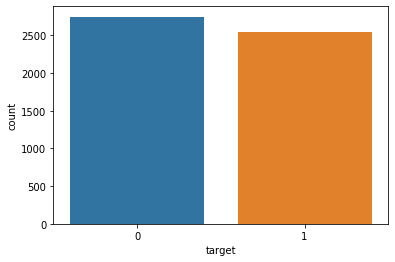

In [7]:
sns.countplot(x= 'target',data = train_df)
plt.show()

Data is distributed between 1 and 0 


In [3]:
## Lets combine test and train data 
combine_df = pd.concat([train_df, test_df], axis=0)

In [4]:
combine_df.shape

(7249, 3)

In [6]:
## Create a function to pre-process the tweet
def pre_process(sentence , stem= True, lemm = False):

    stemmer = PorterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
   # spell = SpellChecker()

    # change sentence to lowercase
    sentence =  sentence.lower() 

    # tokenise sentence into words
    tokenize = TweetTokenizer()
    words = tokenize.tokenize(sentence)

    ##  @[user]-> AT_USER; as this is used to reference the user
    words =  [re.sub('@[\w]+', 'AT_USER', word) for word in words]

    ## Change URL to URL tag
    words =  [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', word) for word in words]

    # remove stop word
    words_list = [word for word in words if word not in stopwords.words('english')]

    ## remove the word which have length of less than 2 word
    words_list = [word for word in words_list if len(word)> 2 ]

    ## As this is tweet of people cal write like heloooooo. in english. max 2 time word is repear 
    pattern = re.compile(r"(.)\1{2,}")
    words_list =  [pattern.sub(r"\1\1", word) for word in words_list]
    

    ## Now also try with spell check to correct the spell
    ##words_list =  [rectify(word) for word in words_list]

    ## Use stemmer which will convert work like learn learning to learn by using grammer define
    if stem:
        words_list = [stemmer.stem(word) for word in words_list]

    ## Use lemmatize which will convert verb to its base form
    if lemm:
        words_list = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words_list]

    return ' '.join(words_list)


In [12]:
## Sample test
word = pre_process('MercyOfAllah In good times wrapped in its finallyyyyyy ?????? granular detail I challenge myself to find meaning and model the humility t https://8into8.com @Arvind', False,False) 
word
## look like function is working fine

'mercyofallah good times wrapped finallyy granular detail challenge find meaning model humility URL AT_USER'

In [7]:
# stem messages
All_tweets = [pre_process(text, stem=True, lemm = False) for text in combine_df.text]

### this step will take time as all clearning of text is happening
## Now in first run we show stem , let check lemm now

##All_tweets = [pre_process(text, stem=False, lemm = True) for text in combine_df.text]
### this step will take time as all clearning of text is happening


In [8]:
# remove special characters, numbers, punctuations
All_tweets = pd.Series(All_tweets).str.replace("[^a-zA-Z#]", " ")

In [9]:
## All Train tweets
All_train_tweets = All_tweets[:5287]
All_test_tweets = All_tweets[5287:]

In [10]:
train_tweets_df = pd.concat([train_df,All_train_tweets], axis=1)
train_tweets_df= train_tweets_df.drop(['ID','text'], axis=1)
train_tweets_df.columns = ['label', 'text']
train_tweets_df.head()

,label,text
0,1,bitcoin halv cancel due
1,0,mercyofallah good time wrap granular detail ch...
2,1,day digit india murder learn onlin busi re...
3,1,india like run remain rna kit essenti test one...
4,0,tough time best way grow learn case teach help...


In [11]:
test_df.reset_index(drop=True, inplace=True)
All_test_tweets.reset_index(drop=True, inplace=True)
test_tweets_df = pd.concat([test_df,All_test_tweets], axis=1)
test_tweets_df= test_tweets_df.drop(['ID','text'], axis=1)
test_tweets_df.columns = ['text']
test_tweets_df.head()

,text
0,explain video take look
1,davey fast ramadan contest
2,doja cat good miss nicki minaj
3,bori johnson cheeri wound action persona may s...
4,man terribl even reason get sport start back


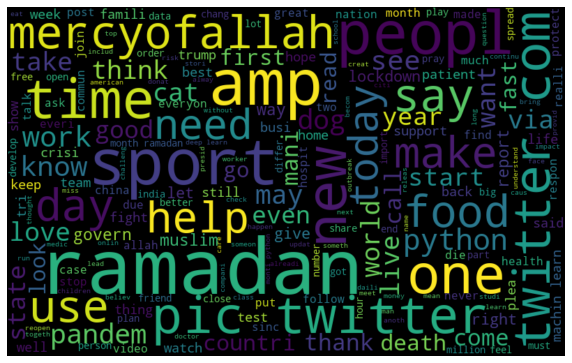

In [19]:
all_words = ' '.join(All_tweets)

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

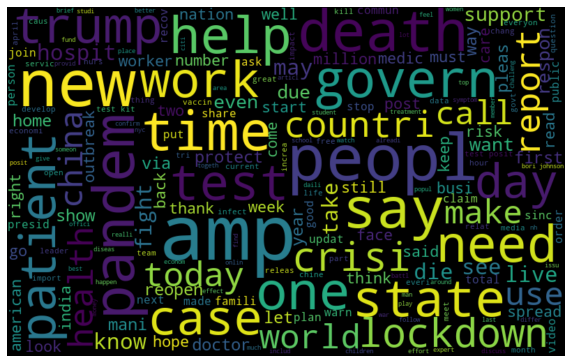

In [20]:
covid_words = ' '.join(train_tweets_df[train_tweets_df.label==1]['text'])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(covid_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can see clearly word like time, lockdown, doctor, test, are frequnt now , 

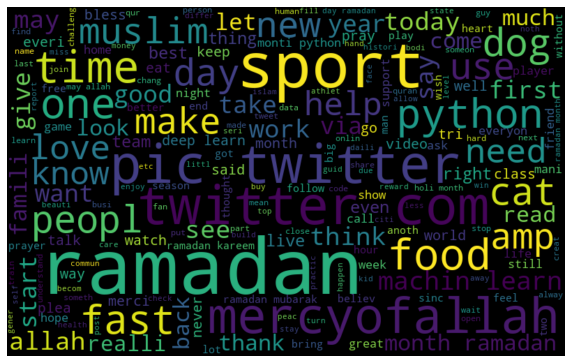

In [21]:
non_covid_words = ' '.join(train_tweets_df[train_tweets_df.label==0]['text'])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(non_covid_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [12]:
def plot_word_frequency(words, top_n=10):
    word_freq = FreqDist(words)
    labels = [element[0] for element in word_freq.most_common(top_n)]
    counts = [element[1] for element in word_freq.most_common(top_n)]
    plot = sns.barplot(labels, counts)
    return plot

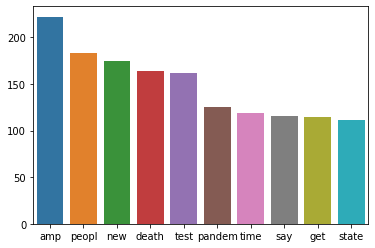

In [23]:
plot_words = covid_words.split()
plot_word_frequency(plot_words, 10)
plt.show()

In [24]:
## word amp look suspicious here , check the record 
pd.options.display.max_colwidth = 200
train_tweets_df[train_tweets_df.text.str.find(' amp ')>0]

,label,text
11,0,best reward human earth understand amp accept islam ahmadiyya may chang
39,1,warn danger begin januari amp next month allow peopl enter cda
44,0,nation volunt appreci month big thank volunt make event amp program success weston club friend weston librari weston citizen observ patrol amp weston sport allianc
57,0,whether music photographi book car amp sport lock podcast discov new voic learn someth new transport new world
83,0,releas detail end lockdown may manufactur construct amp wholesal con
...,...,...
5179,1,news keep talk amp talk enough pandem ppl amp famili lose job indefinit incom feed famili ny servic joke
5190,1,devo amp princ famili long record financ danger right wing extremist individu amp caus
5235,1,time abandon asset base commun develop abcd principl amp practic favor top defici
5251,0,use feel sorri india would fear captain amp face imran khan via


In [13]:
train_tweets_df['text'] = pd.Series(train_tweets_df['text']).str.replace(" amp ", " ")


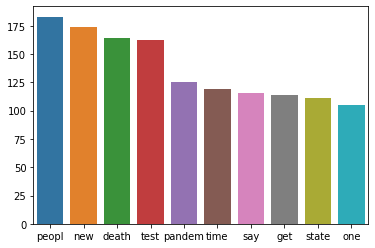

In [15]:
covid_words = ' '.join(train_tweets_df[train_tweets_df.label==1]['text'])
plot_words = covid_words.split()
plot_word_frequency(plot_words, 10)
plt.show()
## Now data looks good

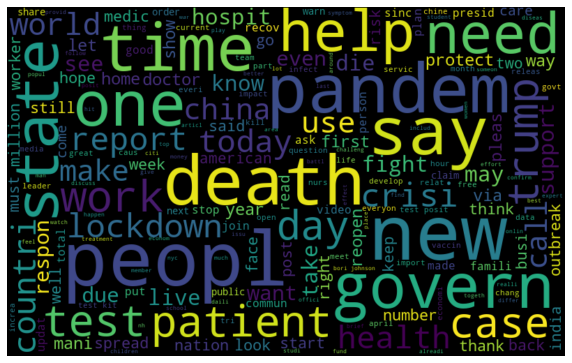

In [27]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(covid_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [84]:
# convert to X and y
X = train_tweets_df.text
y = train_tweets_df.label
print(X.shape)
print(y.shape)

(5287,)
(5287,)


In [29]:
pd.options.display.max_colwidth = 100
train_tweets_df.text


0                                                                                   bitcoin halv cancel due
1                                mercyofallah good time wrap granular detail challeng find mean model humil
2                                                        day digit india murder learn onlin busi restor amp
3                                                   india like run remain rna kit essenti test one week gov
4                             tough time best way grow learn case teach help peopl learn connect sport anal
                                                       ...                                                 
5282                                      spread novel among asylum seeker add pile alarm dire circumst ten
5283    hundr jewish patient treat arab practition might never meet outsid hospit sick palestinian get c...
5284                    beat honestli peopl follow sport fan share tweet sport messag board sake shit giggl
5285    help reach peopl don

In [85]:
# splitting into test and train fro model
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [31]:
X_train.head()

3172                     newspap headlin mon apr      insight mahama say govt humanitarian intervent abysma
1020                        someon known develop fever chill bodi pain cough friday visit doc doc said need
1687                                                          ramadan mean parti mate atleast get tit degre
993                                    gig worker face imposs choic lack incom infect new report survey cov
2305    nice improv object detect crowd scene contribut emd loss function refin modul increas precis rec...
Name: text, dtype: object

In [32]:
y_train.head()

3172    1
1020    1
1687    0
993     1
2305    0
Name: label, dtype: int64

In [87]:
# vectorizing the sentences; 
##from sklearn.feature_extraction.text import CountVectorizer
##vect = CountVectorizer()

## Now we got accuracy of 88% in first run and sencitivity as 86%
##let try with tid-df

vect = TfidfVectorizer()


In [89]:
vect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [90]:
# vocab size
len(vect.vocabulary_.keys())

8530

In [91]:
# transforming the train and test datasets
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

In [37]:
pd.DataFrame(X_train_transformed.toarray(), columns = vect.get_feature_names())

,aadil,aamiin,aap,aapg,aaron,aatay,aba,abandon,abaryebpov,abba,...,zine,zkm,zombi,zone,zoo,zoom,zoomer,zoomi,zrouf,zudo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# training the NB model and making predictions

mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed,y_train)

# predict class
y_pred_class = mnb.predict(X_test_transformed)

## predict probabilities 
y_pred_proba = mnb.predict_proba(X_test_transformed)

In [39]:
# printing the overall accuracy


print(accuracy_score(y_test,y_pred_class))
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))

0.8827534039334342
[[632  64]
 [ 91 535]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       696
           1       0.89      0.85      0.87       626

    accuracy                           0.88      1322
   macro avg       0.88      0.88      0.88      1322
weighted avg       0.88      0.88      0.88      1322



In [40]:
confusion = confusion_matrix(y_test, y_pred_class)
TN  = confusion[0,0]
TP  = confusion[1,1]
FP  = confusion[0,1]
FN  = confusion[1,0]

sensitivity = TP / float(FN + TP)
print("sensitivity",sensitivity)

specificity = TN / float(TN + FP)
print("specificity",specificity)



sensitivity 0.854632587859425
specificity 0.9080459770114943


In [41]:


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

0.9532770555616761


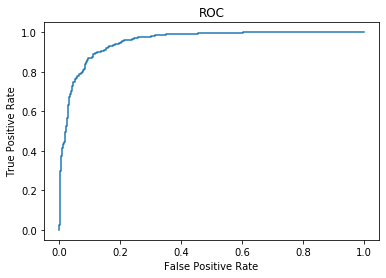

In [42]:
# plotting the ROC curve
%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

In [43]:
## Lets try with BernoulliNB



# instantiate bernoulli NB object
bnb = BernoulliNB()

# fit 
bnb.fit(X_train_transformed,y_train)

# predict class
y_pred_class = bnb.predict(X_test_transformed)

# predict probability
y_pred_proba =bnb.predict_proba(X_test_transformed)

In [44]:
print(accuracy_score(y_test,y_pred_class))
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))

0.8910741301059002
[[631  65]
 [ 79 547]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       696
           1       0.89      0.87      0.88       626

    accuracy                           0.89      1322
   macro avg       0.89      0.89      0.89      1322
weighted avg       0.89      0.89      0.89      1322



In [45]:
confusion = confusion_matrix(y_test, y_pred_class)
TN  = confusion[0,0]
TP  = confusion[1,1]
FP  = confusion[0,1]
FN  = confusion[1,0]

sensitivity = TP / float(FN + TP)
print("sensitivity",sensitivity)

specificity = TN / float(TN + FP)
print("specificity",specificity)

## Here sensitivity is more than MultinomialNB

sensitivity 0.8738019169329073
specificity 0.9066091954022989


0.9593707539201646


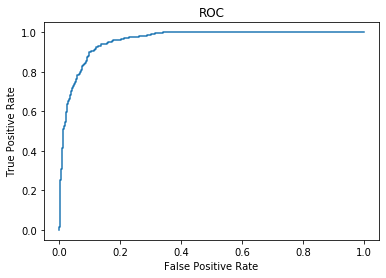

In [46]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)
%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

In [48]:
## lets try with SVM
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly', 'sigmoid']}

SVC_grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)

## Now fit the model
SVC_grid.fit(X_train_transformed,y_train)

.... C=10, gamma=1, kernel=sigmoid, total=   2.2s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ................... C=10, gamma=0.1, kernel=linear, total=   2.3s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ................... C=10, gamma=0.1, kernel=linear, total=   2.3s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ................... C=10, gamma=0.1, kernel=linear, total=   2.4s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ................... C=10, gamma=0.1, kernel=linear, total=   2.2s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ................... C=10, gamma=0.1, kernel=linear, total=   1.9s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   2.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......................

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [49]:
SVC_grid.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [50]:
SVC_best = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
SVC_best.fit(X_train_transformed,y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [51]:
y_test_predicted = SVC_best.predict(X_test_transformed)
y_pred_proba = SVC_best.predict_proba(X_test_transformed)

In [53]:
print(accuracy_score(y_test,y_pred_class))
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))
confusion = confusion_matrix(y_test, y_pred_class)
TN  = confusion[0,0]
TP  = confusion[1,1]
FP  = confusion[0,1]
FN  = confusion[1,0]

sensitivity = TP / float(FN + TP)
print("sensitivity",sensitivity)

specificity = TN / float(TN + FP)
print("specificity",specificity)


0.8910741301059002
[[631  65]
 [ 79 547]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       696
           1       0.89      0.87      0.88       626

    accuracy                           0.89      1322
   macro avg       0.89      0.89      0.89      1322
weighted avg       0.89      0.89      0.89      1322

sensitivity 0.8738019169329073
specificity 0.9066091954022989


In [56]:

knn_grid = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(2, 15)}

knn_gscv = GridSearchCV(knn_grid, param_grid, cv=5)

## Now fit the model
knn_gscv.fit(X_train_transformed,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [58]:
knn_gscv.best_params_

{'n_neighbors': 13}

In [59]:

## By Grid search nk =13
KNN_best = KNeighborsClassifier(n_neighbors=13)
KNN_best.fit(X_train_transformed,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

In [60]:
y_test_predicted = KNN_best.predict(X_test_transformed)
y_pred_proba = KNN_best.predict_proba(X_test_transformed)

In [61]:
print(accuracy_score(y_test,y_pred_class))
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))
confusion = confusion_matrix(y_test, y_pred_class)
TN  = confusion[0,0]
TP  = confusion[1,1]
FP  = confusion[0,1]
FN  = confusion[1,0]

sensitivity = TP / float(FN + TP)
print("sensitivity",sensitivity)

specificity = TN / float(TN + FP)
print("specificity",specificity)


0.8910741301059002
[[631  65]
 [ 79 547]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       696
           1       0.89      0.87      0.88       626

    accuracy                           0.89      1322
   macro avg       0.89      0.89      0.89      1322
weighted avg       0.89      0.89      0.89      1322

sensitivity 0.8738019169329073
specificity 0.9066091954022989


In [62]:
# try with random forest classifier from sklearn library

param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

grid_search.fit(X_train_transformed,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [63]:
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.5170239618131864 using {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 100}


In [92]:
rfc_best = RandomForestClassifier(bootstrap=True,
                             max_depth=4,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=5,
                             n_estimators=100)
rfc_best.fit(X_train_transformed,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [93]:
y_test_predicted = rfc_best.predict(X_test_transformed)
y_pred_proba = rfc_best.predict_proba(X_test_transformed)

In [94]:
y_pred_proba

array([[0.51722825, 0.48277175],
       [0.51722825, 0.48277175],
       [0.51722825, 0.48277175],
       ...,
       [0.51722825, 0.48277175],
       [0.51722825, 0.48277175],
       [0.51722825, 0.48277175]])

In [66]:
print(accuracy_score(y_test,y_pred_class))
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))
confusion = confusion_matrix(y_test, y_pred_class)
TN  = confusion[0,0]
TP  = confusion[1,1]
FP  = confusion[0,1]
FN  = confusion[1,0]

sensitivity = TP / float(FN + TP)
print("sensitivity",sensitivity)

specificity = TN / float(TN + FP)
print("specificity",specificity)

0.8910741301059002
[[631  65]
 [ 79 547]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       696
           1       0.89      0.87      0.88       626

    accuracy                           0.89      1322
   macro avg       0.89      0.89      0.89      1322
weighted avg       0.89      0.89      0.89      1322

sensitivity 0.8738019169329073
specificity 0.9066091954022989


In [68]:
voting = VotingClassifier(estimators=[('BernoulliNB',bnb ), ('svc', SVC_best),
('rforest', rfc_best)], voting='soft', n_jobs=3)
voting.fit(X_train_transformed,y_train)

VotingClassifier(estimators=[('BernoulliNB',
                              BernoulliNB(alpha=1.0, binarize=0.0,
                                          class_prior=None, fit_prior=True)),
                             ('svc',
                              SVC(C=10, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=1, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('rforest',
                              Ra...
                                                     criterion='gini',
                                                     max_depth=4,
                                                     max_features=5,
                                                     max_l

In [69]:
y_test_predicted = voting.predict(X_test_transformed)
y_pred_proba = voting.predict_proba(X_test_transformed)

In [70]:
print(accuracy_score(y_test,y_pred_class))
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))
confusion = confusion_matrix(y_test, y_pred_class)
TN  = confusion[0,0]
TP  = confusion[1,1]
FP  = confusion[0,1]
FN  = confusion[1,0]

sensitivity = TP / float(FN + TP)
print("sensitivity",sensitivity)

specificity = TN / float(TN + FP)
print("specificity",specificity)

0.8910741301059002
[[631  65]
 [ 79 547]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       696
           1       0.89      0.87      0.88       626

    accuracy                           0.89      1322
   macro avg       0.89      0.89      0.89      1322
weighted avg       0.89      0.89      0.89      1322

sensitivity 0.8738019169329073
specificity 0.9066091954022989


Prepare for submission


In [18]:
X_train = train_tweets_df.text
y_train = train_tweets_df.label
X_test  = test_tweets_df.text

vect = TfidfVectorizer()
vect.fit(X_train)

X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

bnb = BernoulliNB()
# fit 
bnb.fit(X_train_transformed,y_train)

SVC_best = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
SVC_best.fit(X_train_transformed,y_train)

rfc_best = RandomForestClassifier(bootstrap=True,
                             max_depth=4,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=5,
                             n_estimators=100)
rfc_best.fit(X_train_transformed,y_train)

voting = VotingClassifier(estimators=[('BernoulliNB',bnb ), ('svc', SVC_best),
('rforest', rfc_best)], voting='soft', n_jobs=3)
voting.fit(X_train_transformed,y_train)


VotingClassifier(estimators=[('BernoulliNB',
                              BernoulliNB(alpha=1.0, binarize=0.0,
                                          class_prior=None, fit_prior=True)),
                             ('svc',
                              SVC(C=10, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=1, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('rforest',
                              Ra...
                                                     criterion='gini',
                                                     max_depth=4,
                                                     max_features=5,
                                                     max_l

In [19]:
y_test_predicted = voting.predict(X_test_transformed)
y_pred_proba = voting.predict_proba(X_test_transformed)

In [22]:
len(y_pred_proba[:,1])

1962

In [28]:
target = pd.Series(y_pred_proba[:,1], name="target")
target = round(target,2)
results = pd.concat([test_df.ID,target],axis=1)
results.to_csv('Output.csv',index=False)